In [1]:
# %pip install -qU graphql-core pandas matplotlib

In [2]:
def print_graphql_file_names():
    graphql_files = [
        "GraphQLClients/spaceXplayground/queries/smoke.graphql",
        "GraphQLClients/spaceXplayground/schema.graphql"
    ]
    
    for file in graphql_files:
        print(file)

print_graphql_file_names()

GraphQLClients/spaceXplayground/queries/smoke.graphql
GraphQLClients/spaceXplayground/schema.graphql


In [3]:
import os
import glob
from collections import defaultdict
from graphql import parse, DocumentNode, OperationDefinitionNode, FragmentDefinitionNode, FieldNode, FragmentSpreadNode, InlineFragmentNode
import pandas as pd
import matplotlib.pyplot as plt
from graphql import parse

In [4]:
SCHEMA_PATH = 'schema.graphql'
QUERIES_PATH = 'queries'

In [5]:
def load_schema(schema_path: str) -> DocumentNode:
    """
    Loads and parses a GraphQL schema from a file.

    Args:
        schema_path (str): The path to the GraphQL schema file.

    Returns:
        DocumentNode: A parsed representation of the GraphQL schema.

    Raises:
        FileNotFoundError: If the schema file does not exist.
        graphql.error.GraphQLError: If the schema cannot be parsed.
    """
    with open(schema_path, 'r') as file:
        schema_str = file.read()
    return parse(schema_str)

In [6]:
def test_load_schema_happy_path(schema_path = SCHEMA_PATH):  # Ensure this file exists and is a valid GraphQL schema
    try:
        result = load_schema(schema_path)
        assert isinstance(result, DocumentNode), "Test failed: Result is not a DocumentNode."
        
        # Check for at least one type definition and print its name
        for definition in result.definitions:
            if hasattr(definition, 'name'):
                print(f"Test passed: Schema loaded successfully with type definition '{definition.name.value}'.")
                break
        else:
            assert False, "Test failed: No type definitions found in the schema."
    except Exception as e:
        raise AssertionError(f"Test failed with exception: {e}")

# Run the test
test_load_schema_happy_path()

Test passed: Schema loaded successfully with type definition 'Address'.


In [7]:
def load_queries(queries_path: str) -> list:
    """
    Loads and reads all GraphQL query files from a specified directory.

    Args:
        queries_path (str): The path to the directory containing GraphQL query files.

    Returns:
        list: A list of tuples, each containing the file path and the content of a GraphQL query file.

    Raises:
        FileNotFoundError: If no GraphQL query files are found in the specified directory.
    """
    query_files = glob.glob(os.path.join(queries_path, '**', '*.graphql'), recursive=True)
    if not query_files:
        raise FileNotFoundError(f"No GraphQL query files found in directory: {queries_path}")
    
    queries = []
    for file_path in query_files:
        with open(file_path, 'r') as file:
            queries.append((file_path, file.read()))
    return queries

In [8]:
def test_load_queries_happy_path(queries_path = QUERIES_PATH):
    """
    Tests the load_queries function with a valid queries path.
    """
    try:
        queries = load_queries(queries_path)
        assert queries, "Test failed: No queries loaded."
        assert len(queries) > 0, "Test failed: Empty queries list returned."
        assert all(isinstance(q, tuple) and len(q) == 2 for q in queries), "Test failed: Invalid query format."
        print(f"Test passed: Loaded {len(queries)} queries successfully.")
    except Exception as e:
        raise AssertionError(f"Test failed with exception: {e}")

# Run the test
test_load_queries_happy_path()

Test passed: Loaded 1 queries successfully.


In [9]:
from graphql.language.ast import (
    OperationDefinitionNode,
    FieldNode,
    FragmentDefinitionNode,
    FragmentSpreadNode,
    InlineFragmentNode,
)
from typing import Set, Dict


def extract_fields(
    node: OperationDefinitionNode,
    fragments: Dict[str, FragmentDefinitionNode],
    parent_path: str = "",
    only_leafs: bool = False,
    verbose: bool = False,
) -> Set[str]:
    """
    Extracts hierarchical fields from a given GraphQL AST node, including nested fields and fragments.

    Args:
        node (OperationDefinitionNode): The GraphQL AST node representing the operation (query, mutation, etc.).
        fragments (Dict[str, FragmentDefinitionNode]): A dictionary of fragment definitions.
        parent_path (str): The hierarchical path of the parent field.
        only_leafs (bool): If True, only includes fields without sub-fields (leaf nodes).
        verbose (bool): If True, prints debug statements.

    Returns:
        Set[str]: A set of hierarchical field names extracted from the node.
    """
    fields = set()

    def traverse_selection(selection, current_path):
        if isinstance(selection, FieldNode):
            field_name = selection.name.value
            hierarchical_field = f"{current_path}.{field_name}" if current_path else field_name
            has_subfields = selection.selection_set is not None

            if verbose:
                print(f"Processing Field: {hierarchical_field} (Has subfields: {has_subfields})")

            # Add field based on only_leafs parameter
            if not only_leafs or (only_leafs and not has_subfields):
                fields.add(hierarchical_field)

            # Recursively process subfields
            if has_subfields:
                for sub_selection in selection.selection_set.selections:
                    traverse_selection(sub_selection, hierarchical_field)

        elif isinstance(selection, FragmentSpreadNode):
            fragment_name = selection.name.value
            if verbose:
                print(f"Processing Fragment Spread: {fragment_name}")
            fragment = fragments.get(fragment_name)
            if fragment:
                for frag_selection in fragment.selection_set.selections:
                    traverse_selection(frag_selection, current_path)  # Use current_path to maintain hierarchy
            else:
                if verbose:
                    print(f"Fragment '{fragment_name}' not found.")

        elif isinstance(selection, InlineFragmentNode):
            type_condition = (
                selection.type_condition.name.value if selection.type_condition else "UnknownType"
            )
            if verbose:
                print(f"Processing Inline Fragment on {type_condition}")
            for inline_selection in selection.selection_set.selections:
                traverse_selection(inline_selection, current_path)  # Use current_path to maintain hierarchy

        else:
            if verbose:
                print(f"Unknown selection type: {type(selection)}")

    for selection in node.selection_set.selections:
        traverse_selection(selection, parent_path)

    return fields

In [10]:
from graphql import parse, DocumentNode
from collections import defaultdict


def test_extract_fields_hierarchical():
    """
    Tests the extract_fields function to ensure it correctly extracts hierarchical field names
    from GraphQL queries, both including all fields and only leaf fields.
    """
    # Define a concise GraphQL schema as a string
    schema_str = """
    type Query {
        book: Book
    }

    type Book {
        title: String
        author: Author
    }

    type Author {
        name: String
    }

    fragment AuthorDetails on Author {
        name
    }
    """

    # Define a simple GraphQL query string
    query_str_all_fields = """
    query {
        book {
            title
            author {
                name
            }
        }
    }
    """

    # Define a GraphQL query string with a fragment
    query_str_with_fragment = """
    query {
        book {
            title
            author {
                ...AuthorDetails
            }
        }
    }
    """

    # Parse the schema and queries into DocumentNodes
    schema: DocumentNode = parse(schema_str)
    query_all_fields = parse(query_str_all_fields)
    query_with_fragment = parse(query_str_with_fragment)

    # Extract fragments from the schema
    fragments = {
        definition.name.value: definition
        for definition in schema.definitions
        if isinstance(definition, FragmentDefinitionNode)
    }

    # Extract operation definitions from the queries
    operations = [
        definition
        for definition in query_all_fields.definitions
        if isinstance(definition, OperationDefinitionNode)
    ]

    operations_with_fragment = [
        definition
        for definition in query_with_fragment.definitions
        if isinstance(definition, OperationDefinitionNode)
    ]

    # Combine all operations for testing
    all_operations = operations + operations_with_fragment

    # Define expected fields for both scenarios
    expected_fields_all = {
        "book",
        "book.title",
        "book.author",
        "book.author.name",
    }

    expected_fields_leafs = {
        "book.title",
        "book.author.name",
    }

    # Aggregate extracted fields
    extracted_fields_all = set()
    extracted_fields_leafs = set()

    # Extract fields with only_leafs=False
    for operation in all_operations:
        fields = extract_fields(
            operation, fragments, parent_path="", only_leafs=False, verbose=False
        )
        extracted_fields_all.update(fields)

    # Extract fields with only_leafs=True
    for operation in all_operations:
        fields = extract_fields(
            operation, fragments, parent_path="", only_leafs=True, verbose=False
        )
        extracted_fields_leafs.update(fields)

    # Assertions for only_leafs=False
    assert (
        extracted_fields_all == expected_fields_all
    ), f"Test failed for all fields: Expected {expected_fields_all}, but got {extracted_fields_all}"

    # Assertions for only_leafs=True
    assert (
        extracted_fields_leafs == expected_fields_leafs
    ), f"Test failed for leaf fields: Expected {expected_fields_leafs}, but got {extracted_fields_leafs}"

    print("Test passed: Both all fields and leaf-only fields were extracted correctly.")


# Run the test
test_extract_fields_hierarchical()

Test passed: Both all fields and leaf-only fields were extracted correctly.


In [11]:
from graphql.language.ast import (
    ObjectTypeDefinitionNode,
    FieldDefinitionNode,
    NamedTypeNode,
    ListTypeNode,
    NonNullTypeNode,
)
from typing import Set


def get_schema_fields(
    schema: DocumentNode, only_leafs: bool = False, parent_path: str = ""
) -> Set[str]:
    """
    Recursively extracts hierarchical field names from a GraphQL schema, starting from the 'Query' type.

    Args:
        schema (DocumentNode): A parsed GraphQL schema represented as a DocumentNode.
        only_leafs (bool): If True, only returns fields that don't have sub-fields (leaf nodes).
                           If False, returns all fields including intermediate nodes.
        parent_path (str): The hierarchical path of the parent field.

    Returns:
        Set[str]: A set of hierarchical field names from the schema, filtered based on the only_leafs parameter.
    """
    fields = set()
    type_definitions = {
        d.name.value: d for d in schema.definitions if isinstance(d, ObjectTypeDefinitionNode)
    }

    def get_named_type(node):
        if isinstance(node, NonNullTypeNode) or isinstance(node, ListTypeNode):
            return get_named_type(node.type)
        elif isinstance(node, NamedTypeNode):
            return node.name.value
        return None

    def extract_fields_from_type(
        type_name: str, current_path: str, visited: Set[str] = None
    ) -> Set[str]:
        if visited is None:
            visited = set()

        if type_name in visited:
            return set()

        visited.add(type_name)
        current_fields = set()
        type_def = type_definitions.get(type_name)

        if not type_def:
            return set()

        for field in type_def.fields:
            field_name = field.name.value
            field_type = get_named_type(field.type)
            has_subfields = field_type in type_definitions

            hierarchical_field = f"{current_path}.{field_name}" if current_path else field_name

            # Add field based on only_leafs parameter
            if not only_leafs or (only_leafs and not has_subfields):
                fields.add(hierarchical_field)

            # Recursively get subfields
            if has_subfields:
                subfields = extract_fields_from_type(
                    field_type, hierarchical_field, visited
                )
                fields.update(subfields)

        return current_fields

    # Start from Query type
    query_type = next(
        (
            d
            for d in schema.definitions
            if isinstance(d, ObjectTypeDefinitionNode) and d.name.value == "Query"
        ),
        None,
    )

    if query_type:
        for field in query_type.fields:
            field_name = field.name.value
            field_type = get_named_type(field.type)
            has_subfields = field_type in type_definitions

            hierarchical_field = field_name

            # Add field based on only_leafs parameter
            if not only_leafs or (only_leafs and not has_subfields):
                fields.add(hierarchical_field)

            # Recursively get subfields
            if has_subfields:
                subfields = extract_fields_from_type(field_type, hierarchical_field)
                fields.update(subfields)

    return fields

In [12]:
from graphql import parse, DocumentNode

def test_get_schema_fields_happy_path():
    """
    Tests the get_schema_fields function to ensure it correctly extracts hierarchical field names
    from a GraphQL schema, both including all fields and only leaf fields.
    """
    # Define a simple GraphQL schema as a string
    schema_str = """
    type Query {
        user: User
        post: Post
        comment: Comment
    }

    type User {
        id: ID
        name: String
        address: Address
    }

    type Address {
        street: String
        city: String
        country: String
    }

    type Post {
        id: ID
        title: String
        author: User
    }

    type Comment {
        id: ID
        content: String
        author: User
    }
    """

    # Parse the schema string into a DocumentNode
    schema: DocumentNode = parse(schema_str)

    # Test with only_leafs=False (include all fields)
    fields_all = get_schema_fields(schema, only_leafs=False)
    expected_fields_all = {
        "user",
        "user.id",
        "user.name",
        "user.address",
        "user.address.street",
        "user.address.city",
        "user.address.country",
        "post",
        "post.id",
        "post.title",
        "post.author",
        "post.author.id",
        "post.author.name",
        "post.author.address",
        "post.author.address.street",
        "post.author.address.city",
        "post.author.address.country",
        "comment",
        "comment.id",
        "comment.content",
        "comment.author",
        "comment.author.id",
        "comment.author.name",
        "comment.author.address",
        "comment.author.address.street",
        "comment.author.address.city",
        "comment.author.address.country",
    }
    assert fields_all == expected_fields_all, f"Test failed for all fields: Expected {expected_fields_all}, but got {fields_all}"

    # Test with only_leafs=True (only fields without children)
    fields_leafs = get_schema_fields(schema, only_leafs=True)
    expected_fields_leafs = {
        "user.id",
        "user.name",
        "user.address.street",
        "user.address.city",
        "user.address.country",
        "post.id",
        "post.title",
        "post.author.id",
        "post.author.name",
        "post.author.address.street",
        "post.author.address.city",
        "post.author.address.country",
        "comment.id",
        "comment.content",
        "comment.author.id",
        "comment.author.name",
        "comment.author.address.street",
        "comment.author.address.city",
        "comment.author.address.country",
    }
    assert (
        fields_leafs == expected_fields_leafs
    ), f"Test failed for leaf fields: Expected {expected_fields_leafs}, but got {fields_leafs}"

    print("Test passed: Both all fields and leaf-only fields were extracted correctly.")

# Run the test
test_get_schema_fields_happy_path()

Test passed: Both all fields and leaf-only fields were extracted correctly.


In [13]:
def parse_schema(schema_path: str, only_leafs: bool = False) -> set:
    """
    Parses a GraphQL schema file and extracts field names recursively.

    Args:
        schema_path (str): The file path to the GraphQL schema.
        only_leafs (bool): If True, only returns fields that don't have sub-fields.
                           If False, returns all fields including intermediate nodes.

    Returns:
        set: A set of field names from the schema, filtered based on the only_leafs parameter.
    """
    schema = load_schema(schema_path)
    schema_fields = get_schema_fields(schema, only_leafs)
    return schema_fields

In [14]:
from graphql import parse, DocumentNode
import os

def test_parse_schema_happy_path():
    """
    Tests the parse_schema function to ensure it correctly extracts hierarchical field names
    from a GraphQL schema, both including all fields and only leaf fields.
    """
    # Define a concise GraphQL schema as a string
    schema_str = """
    type Query {
        book: Book
    }

    type Book {
        title: String
        author: Author
    }

    type Author {
        name: String
    }
    """

    # Write the schema to a temporary file
    schema_file_path = 'temp_schema.graphql'
    with open(schema_file_path, 'w') as schema_file:
        schema_file.write(schema_str)

    try:
        # Test with only_leafs=False (include all fields)
        fields_all = parse_schema(schema_file_path, only_leafs=False)
        expected_fields_all = {
            "book",
            "book.title",
            "book.author",
            "book.author.name",
        }
        assert fields_all == expected_fields_all, f"Test failed for all fields: Expected {expected_fields_all}, but got {fields_all}"

        # Test with only_leafs=True (only fields without children)
        fields_leafs = parse_schema(schema_file_path, only_leafs=True)
        expected_fields_leafs = {
            "book.title",
            "book.author.name",
        }
        assert fields_leafs == expected_fields_leafs, f"Test failed for leaf fields: Expected {expected_fields_leafs}, but got {fields_leafs}"

        print("Test passed: Both all fields and leaf-only fields were extracted correctly.")
    finally:
        # Clean up the temporary file
        os.remove(schema_file_path)

# Run the test
test_parse_schema_happy_path()

Test passed: Both all fields and leaf-only fields were extracted correctly.


In [15]:
# /Users/gp/Library/CloudStorage/Dropbox/downloads/agile_actors/projs/msTests/GraphQLClients/spaceXplayground/coverage.ipynb
from collections import defaultdict
from graphql import parse, DocumentNode, OperationDefinitionNode, FragmentDefinitionNode

def parse_queries_and_extract_fields(queries: list, only_leafs: bool = False) -> tuple[defaultdict, set]:
    """
    Parses a list of GraphQL query strings and extracts hierarchical field usage information.

    Args:
        queries (list): A list of tuples, each containing a file path and a GraphQL query string.
        only_leafs (bool): If True, only includes fields without sub-fields (leaf nodes).
                           If False, includes all fields.

    Returns:
        tuple[defaultdict, set]: A tuple containing:
            - defaultdict: A dictionary where keys are hierarchical field names and values are the count of how many GraphQL files each field is used in.
            - set: A set of all unique hierarchical field names used across all queries.
    """
    field_usage = defaultdict(int)
    used_fields = set()

    for file_path, query_str in queries:
        # Temporary set to hold unique fields per file
        temp_used_fields = set()
        try:
            document = parse(query_str)
            # Extract fragments from the current document
            fragments = {definition.name.value: definition 
                         for definition in document.definitions 
                         if isinstance(definition, FragmentDefinitionNode)}
            for definition in document.definitions:
                if isinstance(definition, OperationDefinitionNode):
                    fields = extract_fields(definition, fragments, only_leafs=only_leafs)
                    temp_used_fields.update(fields)
        except Exception as e:
            print(f"Error parsing {file_path}: {e}")
            continue  # Skip this query if there's a parsing error

        # Increment field usage counts based on unique fields in this file
        for field in temp_used_fields:
            field_usage[field] += 1
            used_fields.add(field)

    return field_usage, used_fields

In [16]:
from collections import defaultdict

def test_parse_queries_and_extract_fields_hierarchical():
    """
    Tests the parse_queries_and_extract_fields function to ensure it correctly extracts
    hierarchical field names from GraphQL queries, both including all fields and only leaf fields.
    """
    # Define a concise GraphQL schema as a string (Note: Not used in the function, but kept for reference)
    schema_str = """
    type Query {
        user: User
        post: Post
        comment: Comment
    }

    type User {
        id: ID
        name: String
        address: Address
    }

    type Address {
        street: String
        city: String
        country: String
    }

    type Post {
        id: ID
        title: String
        author: User
    }

    type Comment {
        id: ID
        content: String
        author: User
    }

    fragment AuthorDetails on User {
        id
        name
        address {
            street
            city
            country
        }
    }
    """

    # Define a list of GraphQL queries as strings, including fragment definitions within queries
    queries = [
        ('query1.graphql', '''
        query {
            user {
                id
                name
            }
            post {
                title
            }
        }
        '''),
        ('query2.graphql', '''
        query {
            user {
                email
            }
            comment {
                content
            }
            authorDetails: user {
                ...AuthorDetails
            }
        }

        fragment AuthorDetails on User {
            id
            name
            address {
                street
                city
                country
            }
        }
        ''')
    ]

    # Define the expected field usage and set of used fields when only_leafs=False
    expected_field_usage_all = defaultdict(int, {
        'user': 2,                  # 'user' appears in both queries
        'user.id': 2,
        'user.name': 2,
        'post': 1,
        'post.title': 1,
        'user.email': 1,
        'comment': 1,
        'comment.content': 1,
        'user.address': 1,
        'user.address.street': 1,
        'user.address.city': 1,
        'user.address.country': 1,
    })
    expected_used_fields_all = {
        'user',
        'user.id',
        'user.name',
        'post',
        'post.title',
        'user.email',
        'comment',
        'comment.content',
        'user.address',
        'user.address.street',
        'user.address.city',
        'user.address.country',
    }

    # Define the expected field usage and set of used fields when only_leafs=True
    expected_field_usage_leafs = defaultdict(int, {
        'user.id': 2,
        'user.name': 2,
        'post.title': 1,
        'user.email': 1,
        'comment.content': 1,
        'user.address.street': 1,
        'user.address.city': 1,
        'user.address.country': 1,
    })
    expected_used_fields_leafs = {
        'user.id',
        'user.name',
        'post.title',
        'user.email',
        'comment.content',
        'user.address.street',
        'user.address.city',
        'user.address.country',
    }

    # Call the function to test with only_leafs=False
    field_usage_all, used_fields_all = parse_queries_and_extract_fields(queries, only_leafs=False)

    # Assertions for only_leafs=False
    if field_usage_all != expected_field_usage_all:
        diff_all = {k: (field_usage_all.get(k, 0), expected_field_usage_all.get(k, 0)) 
                    for k in set(field_usage_all) | set(expected_field_usage_all) 
                    if field_usage_all.get(k, 0) != expected_field_usage_all.get(k, 0)}
        raise AssertionError(f"Test failed for all fields. Differences: {diff_all}")

    if used_fields_all != expected_used_fields_all:
        diff_used_all = (used_fields_all - expected_used_fields_all) | (expected_used_fields_all - used_fields_all)
        raise AssertionError(f"Test failed for used fields (all). Differences: {diff_used_all}")

    # Call the function to test with only_leafs=True
    field_usage_leafs, used_fields_leafs = parse_queries_and_extract_fields(queries, only_leafs=True)

    # Assertions for only_leafs=True
    if field_usage_leafs != expected_field_usage_leafs:
        diff_leafs = {k: (field_usage_leafs.get(k, 0), expected_field_usage_leafs.get(k, 0)) 
                      for k in set(field_usage_leafs) | set(expected_field_usage_leafs) 
                      if field_usage_leafs.get(k, 0) != expected_field_usage_leafs.get(k, 0)}
        raise AssertionError(f"Test failed for leaf fields. Differences: {diff_leafs}")

    if used_fields_leafs != expected_used_fields_leafs:
        diff_used_leafs = (used_fields_leafs - expected_used_fields_leafs) | (expected_used_fields_leafs - used_fields_leafs)
        raise AssertionError(f"Test failed for used fields (leafs). Differences: {diff_used_leafs}")

    print("Test passed: Extracted field usage and used fields match the expected hierarchical values.")

# Run the test
test_parse_queries_and_extract_fields_hierarchical()

Test passed: Extracted field usage and used fields match the expected hierarchical values.


In [17]:
def calculate_coverage(schema_fields: set, used_fields: set, normalize: bool = False) -> tuple[float, set, set]:
    """
    Calculates the coverage percentage of schema fields that are used in queries.

    Args:
        schema_fields (set): Set of all hierarchical field names defined in the schema.
        used_fields (set): Set of all hierarchical field names used in queries.
        normalize (bool): If True, convert all field names to lowercase for comparison.

    Returns:
        tuple:
            - float: Coverage percentage.
            - set: Covered fields.
            - set: Uncovered fields.
    """
    if not isinstance(schema_fields, set) or not isinstance(used_fields, set):
        raise TypeError("Both schema_fields and used_fields must be sets.")

    if normalize:
        schema_fields = {field.lower() for field in schema_fields}
        used_fields = {field.lower() for field in used_fields}

    if not schema_fields:
        return 0.0, set(), set()

    covered = schema_fields.intersection(used_fields)
    uncovered = schema_fields.difference(used_fields)
    coverage_percentage = (len(covered) / len(schema_fields)) * 100
    return coverage_percentage, covered, uncovered

In [18]:
def calculate_coverage(schema_fields: set, used_fields: set) -> tuple[float, set, set]:
    """
    Calculates the coverage percentage of schema fields that are used in queries.

    Args:
        schema_fields (set): Set of all hierarchical field names defined in the schema.
        used_fields (set): Set of all hierarchical field names used in queries.

    Returns:
        tuple:
            - float: Coverage percentage.
            - set: Covered fields.
            - set: Uncovered fields.
    """
    if not isinstance(schema_fields, set) or not isinstance(used_fields, set):
        raise TypeError("Both schema_fields and used_fields must be sets.")

    if not schema_fields:
        return 0.0, set(), set()

    covered = schema_fields.intersection(used_fields)
    uncovered = schema_fields.difference(used_fields)
    coverage_percentage = (len(covered) / len(schema_fields)) * 100
    return coverage_percentage, covered, uncovered

def test_calculate_coverage():
    # Define a set of schema fields
    schema_fields = {
        'user.id',
        'user.name',
        'user.email',
        'user.address.street',
        'user.address.city',
        'user.address.country',
        'post.id',
        'post.title',
        'post.author',
        'comment.id',
        'comment.content',
        'comment.author',
    }

    # Define a set of used fields from queries
    used_fields = {
        'user.id',
        'user.name',
        'user.email',
        'user.address.street',
        'user.address.city',
        'user.address.country',
        'post.title',
        'comment.content',
    }

    # Expected results
    expected_coverage_percentage = (8 / 12) * 100  # 66.67%
    expected_covered_fields = {
        'user.id',
        'user.name',
        'user.email',
        'user.address.street',
        'user.address.city',
        'user.address.country',
        'post.title',
        'comment.content',
    }
    expected_uncovered_fields = {
        'post.id',
        'post.author',
        'comment.id',
        'comment.author',
    }

    # Calculate coverage
    coverage_percentage, covered_fields, uncovered_fields = calculate_coverage(schema_fields, used_fields)

    # Assertions
    assert abs(coverage_percentage - expected_coverage_percentage) < 0.01, "Coverage percentage does not match expected value."
    assert covered_fields == expected_covered_fields, "Covered fields do not match expected fields."
    assert uncovered_fields == expected_uncovered_fields, "Uncovered fields do not match expected fields."

    print("All tests passed!")

# Run the test
test_calculate_coverage()

All tests passed!


In [19]:
def generate_report(coverage: float, field_usage: defaultdict, schema_fields: set, uncovered_fields: set, depth: int = None):
    """
    Generates a comprehensive coverage report.

    Args:
        coverage (float): Overall coverage percentage.
        field_usage (defaultdict): Dictionary mapping field names to their usage counts.
        schema_fields (set): Set of all schema fields.
        uncovered_fields (set): Set of schema fields not covered by any queries.
        depth (int, optional): The depth level for aggregating fields in the plot.
                               - depth=1: Top-level fields (e.g., 'launchesUpcoming')
                               - depth=2: Second-level fields (e.g., 'launchesUpcoming.rocket')
                               - depth=None: No aggregation, plot all fields individually
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Print Coverage Summary
    print(f"Schema Coverage: {coverage:.2f}%\n")
    print(f"Total Fields: {len(schema_fields)}")
    print(f"Covered Fields: {len(schema_fields) - len(uncovered_fields)}")
    print(f"Uncovered Fields: {len(uncovered_fields)}\n")

    # Create a DataFrame for detailed report
    data = []
    for field in schema_fields:
        usage = field_usage.get(field, 0)
        data.append({'Field': field, 'Usage Count': usage, 'Covered': field not in uncovered_fields})
    df = pd.DataFrame(data)
    df = df.sort_values(by='Usage Count', ascending=False)

    # Display Detailed Field Usage
    print("Detailed Field Usage:")
    print(df.to_string(index=False))

    # Aggregation Function
    def aggregate_field(field: str, depth: int) -> str:
        parts = field.split('.')
        if depth is None or depth <= 0 or depth > len(parts):
            return field
        return '.'.join(parts[:depth])

    # Prepare Data for Plotting
    if depth is not None:
        # Aggregate fields based on the specified depth
        df['Aggregated Field'] = df['Field'].apply(lambda x: aggregate_field(x, depth))
        aggregated_df = df.groupby('Aggregated Field')['Usage Count'].sum().reset_index()
        
        # Sort aggregated data
        aggregated_df = aggregated_df.sort_values(by='Usage Count', ascending=False)
        
        # Plotting the aggregated coverage
        plt.figure(figsize=(12, 8))
        plt.bar(aggregated_df['Aggregated Field'], aggregated_df['Usage Count'], color='blue')
        plt.title(f'GraphQL Schema Field Usage (Aggregated at Depth {depth})')
        plt.xlabel('Aggregated Fields')
        plt.ylabel('Total Usage Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('schema_coverage_chart_aggregated.png')
        plt.show()
    else:
        # Plotting the coverage without aggregation (current implementation)
        plt.figure(figsize=(12, 8))

        # Separate covered and uncovered fields
        covered_df = df[df['Covered'] == True]
        uncovered_df = df[df['Covered'] == False]

        # Plot covered fields
        covered_df.plot(kind='bar', x='Field', y='Usage Count', color='green', label='Covered Fields', ax=plt.gca())

        # Plot uncovered fields on the same axis
        if not uncovered_df.empty:
            uncovered_df.plot(kind='bar', x='Field', y='Usage Count', color='red', label='Uncovered Fields', ax=plt.gca())

        plt.title('GraphQL Schema Field Usage')
        plt.xlabel('Fields')
        plt.ylabel('Usage Count')
        plt.legend()
        plt.tight_layout()
        plt.savefig('schema_coverage_chart.png')
        plt.show()

    # Optionally, save the DataFrame to a CSV for further analysis
    df.to_csv('schema_coverage_report.csv', index=False)

In [20]:
schema_fields = parse_schema(SCHEMA_PATH)
queries = load_queries(QUERIES_PATH)

In [21]:
field_usage, used_fields = parse_queries_and_extract_fields(queries)

In [22]:
used_fields

{'company', 'company.ceo', 'company.coo', 'roadster', 'roadster.apoapsis_au'}

In [23]:
assert used_fields.issubset(schema_fields), "All used fields must be defined in the schema"

In [24]:
field_usage, used_fields = parse_queries_and_extract_fields(queries)
assert used_fields.issubset(schema_fields), "All used fields must be defined in the schema"

In [25]:
coverage, covered, uncovered = calculate_coverage(schema_fields, used_fields)
coverage

0.1718213058419244

Schema Coverage: 0.17%

Total Fields: 2910
Covered Fields: 5
Uncovered Fields: 2905

Detailed Field Usage:
                                                                                     Field  Usage Count  Covered
                                                                               company.ceo            1     True
                                                                               company.coo            1     True
                                                                                  roadster            1     True
                                                                      roadster.apoapsis_au            1     True
                                                                                   company            1     True
                                                                   capsulesUpcoming.status            0    False
                                         launchpads.vehicles_launched.second_stage.engines            

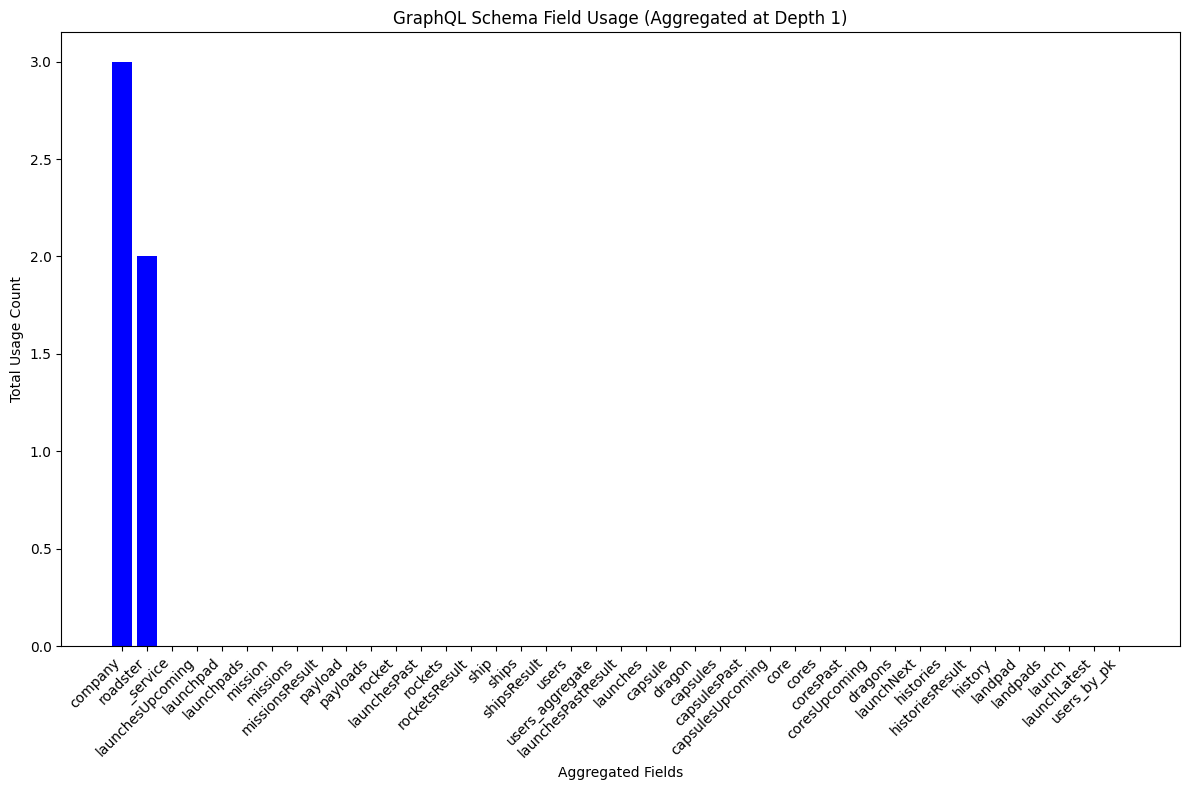

In [28]:
generate_report(coverage, field_usage, schema_fields, uncovered, depth=1)